# Audio Processing
Classify with spectrograms
## Assignment 2
- Sameera Holy SHEIK ABDULLAH

# Import Libraries



In [64]:
import tensorflow as tf
import pandas as pd
import keras
from keras.preprocessing import image
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
import os, numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import Adam, SGD
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator

In [2]:
print(tf.__version__)

2.12.0


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [60]:
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df)+1)

    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)

    plt.show();

# Problem: Classify audio words into its category



# Load Dataset

In [5]:
trainpath = r"drive/MyDrive/EPITA/Signal Processing/Assi 2/data/spectrogram/train"
testpath = r"drive/MyDrive/EPITA/Signal Processing/Assi 2/data/spectrogram/test"

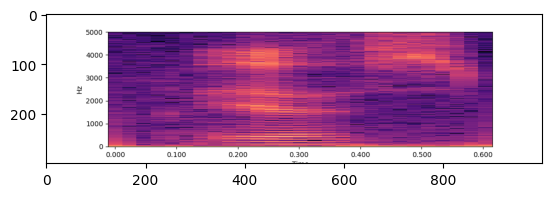

In [11]:
yes = os.path.join(trainpath, "yes/")
filename = yes+'fde2dee7_nohash_1.png'
image = imread(filename)
plt.imshow(image)

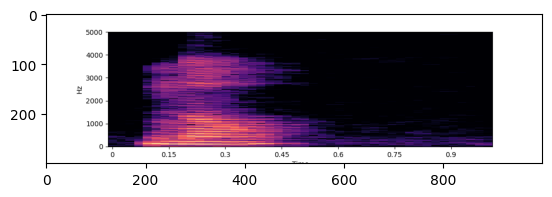

In [12]:
no = os.path.join(trainpath, "no/")
filename = no+'ffd2ba2f_nohash_4.png'
image = imread(filename)
plt.imshow(image)

## Load Images for training and testing

In [13]:
trdata = ImageDataGenerator(preprocessing_function=preprocess_input)
training_set = trdata.flow_from_directory(directory=trainpath,batch_size=20,class_mode='binary', target_size=(224,224))
tsdata = ImageDataGenerator(preprocessing_function=preprocess_input)
test_set = tsdata.flow_from_directory(directory=testpath,batch_size=10,class_mode='binary', target_size=(224,224))

Found 1500 images belonging to 5 classes.
Found 150 images belonging to 5 classes.


## Data Augmentation

ImageDataGenerator is used to perfrom data augmentarion and rescaling of the input images which helps the model to train better and not overfit. It is applied on the train and test images

In [14]:
CLASS_NAMES = ["yes", "no", "wow", "left", "right"]

In [41]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

print("Training Set:")
training_set = train_datagen.flow_from_directory(trainpath,
                                                  target_size = (224,224),
                                                  batch_size = 32,
                                                  classes = CLASS_NAMES,
                                                  class_mode = "categorical")

print("\nTest Set:")
test_set = test_datagen.flow_from_directory(testpath,
                                            target_size = (224,224),
                                            batch_size = 32,
                                            classes = CLASS_NAMES,
                                            class_mode = 'categorical')

Training Set:
Found 1500 images belonging to 5 classes.

Test Set:
Found 150 images belonging to 5 classes.


## VGG16 Pretrained Model

- Using the weights from imagenet to get the pretrained model.
- The final layer is set to 5 neurons and softmax as activation function because we have multi class.
- include_top is set to False as we are adding a flatten and dense after the pretrained vgg model

In [47]:
vgg = VGG16(
    input_shape=[224, 224, 3],
    include_top=False,
    weights='imagenet')

# x = Flatten()(vgg.output)
x = GlobalAveragePooling2D()(vgg.output)
x = Dense(16, activation = "relu")(x)
final_layer = Dense(5, activation='softmax')(x)

## Create the model

- As the classes are multiclass, we are using "categorical cross entropy".
- After different trials, the learning rate is set to 0.0001 for the model to converge slowly and potentially not miss the optimal solution

In [48]:
model = Model(vgg.input, final_layer)
model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.001), metrics = 'accuracy')
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## Early Stopping

It is used to stop the model early
- to monitor the training "loss"
- "min" is used as mode as the monitored metric "loss" should decrease to be considered an improvement
- patience is set to 7, it is like a stopping parameter. When there is no improvement for continuous 7 epochs, the training will be stopped.

In [49]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=7, restore_best_weights=True)

## Train the model

In [52]:
epoch = 20

In [55]:
history = model.fit(training_set,
                    steps_per_epoch = training_set.samples//training_set.batch_size,
                    validation_data = test_set,
                    epochs = epoch,
                    callbacks=[early_stopping])

Epoch 1/20
46/46 [==============================] - 749s 16s/step - loss: 1.6129 - accuracy: 0.2023 - val_loss: 1.6015 - val_accuracy: 0.2133
Epoch 2/20
46/46 [==============================] - 38s 822ms/step - loss: 1.5999 - accuracy: 0.2234 - val_loss: 1.5924 - val_accuracy: 0.2133
Epoch 3/20
46/46 [==============================] - 38s 814ms/step - loss: 1.5917 - accuracy: 0.2337 - val_loss: 1.5827 - val_accuracy: 0.2400
Epoch 4/20
46/46 [==============================] - 37s 810ms/step - loss: 1.5825 - accuracy: 0.2493 - val_loss: 1.5710 - val_accuracy: 0.3467
Epoch 5/20
46/46 [==============================] - 38s 815ms/step - loss: 1.5723 - accuracy: 0.2909 - val_loss: 1.5595 - val_accuracy: 0.3667
Epoch 6/20
46/46 [==============================] - 36s 783ms/step - loss: 1.5554 - accuracy: 0.2997 - val_loss: 1.5418 - val_accuracy: 0.3533
Epoch 7/20
46/46 [==============================] - 38s 813ms/step - loss: 1.5419 - accuracy: 0.3181 - val_loss: 1.5289 - val_accuracy: 0.3133


In [57]:
history1 = model.fit(training_set,
                    steps_per_epoch = training_set.samples//training_set.batch_size,
                    validation_data = test_set,
                    epochs = epoch,
                    callbacks=[early_stopping])

Epoch 1/20
46/46 [==============================] - 38s 831ms/step - loss: 1.0444 - accuracy: 0.6322 - val_loss: 0.9304 - val_accuracy: 0.7000
Epoch 2/20
46/46 [==============================] - 38s 830ms/step - loss: 0.9251 - accuracy: 0.6492 - val_loss: 0.7982 - val_accuracy: 0.7000
Epoch 3/20
46/46 [==============================] - 38s 810ms/step - loss: 0.8482 - accuracy: 0.6935 - val_loss: 1.9006 - val_accuracy: 0.3533
Epoch 4/20
46/46 [==============================] - 37s 803ms/step - loss: 0.8297 - accuracy: 0.6921 - val_loss: 0.8497 - val_accuracy: 0.7667
Epoch 5/20
46/46 [==============================] - 37s 785ms/step - loss: 0.8791 - accuracy: 0.7050 - val_loss: 0.8451 - val_accuracy: 0.6933
Epoch 6/20
46/46 [==============================] - 37s 810ms/step - loss: 0.6988 - accuracy: 0.7568 - val_loss: 0.5035 - val_accuracy: 0.8667
Epoch 7/20
46/46 [==============================] - 37s 800ms/step - loss: 0.6461 - accuracy: 0.7752 - val_loss: 0.6067 - val_accuracy: 0.7933

## Plot the training vs validation loss

In [59]:
history.history['loss'].extend(history1.history['loss'])

In [62]:
history.history['val_loss'].extend(history1.history['val_loss'])

In [61]:
history.history['accuracy'].extend(history1.history['accuracy'])
history.history['val_accuracy'].extend(history1.history['val_accuracy'])

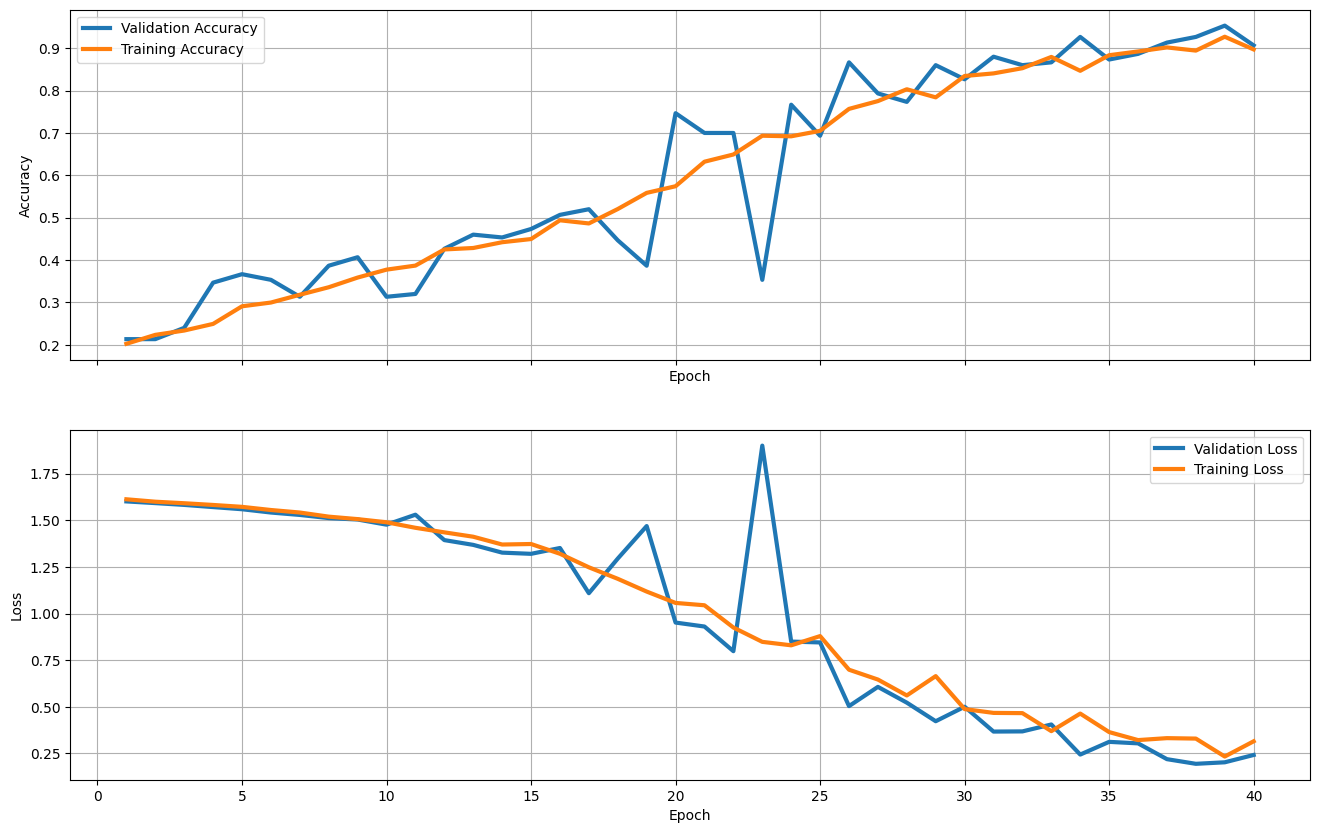

In [65]:
plot_results(history)

Finally we have the best model of accuracy greater than 85% with VGG16 model